In [1]:
import os
import glob
import numpy as np
import pandas as pd

In [2]:
# workdir = "/home/jhli/H2O-Ar-pes/cqpes-legacy-delta-machine-learning/al-model-2024-10-11 11:07:09.729765"  # -1.5
# workdir = "/home/jhli/H2O-Ar-pes/cqpes-legacy-delta-machine-learning/al-model-2024-10-11 11:35:20.310631"  # -2.0
workdir = "/home/jhli/H2O-Ar-pes/cqpes-legacy-delta-machine-learning/al-model-2024-10-11 12:02:14.630890"  # -1.0
# workdir = "/home/jhli/H2O-Ar-pes/cqpes-legacy-delta-machine-learning/al-model-2024-10-11 12:36:10.818096"  # -2.5

In [3]:
def parse_log(log):
    rmse = []
    mae = []

    contents = []
    with open(log) as f:
        while line := f.readline():
            # print(line)
            line = line.rstrip()

            if len(line) > 0:
                # print(line)
                contents.append(line)

    while len(contents) > 0:
        line = contents.pop(0)

        if "rmse =" in line:
            line = contents.pop(0)
            rmse.append(float(line))

        if "mae =" in line:
            line = contents.pop(0)
            mae.append(float(line))

    return [rmse, mae]

In [4]:
def get_logs(workdir):
    query_dir_list = sorted(glob.glob(os.path.join(workdir, "*")))

    rmse_mean_list = []
    rmse_min_list = []
    
    for query_dir in query_dir_list:
        ckpt_dir_list = sorted(glob.glob(os.path.join(query_dir, "model-*")))

        rmse_committee = []

        for ckpt_dir in ckpt_dir_list:
            log = os.path.join(ckpt_dir, "potfit.log")
            res = parse_log(log)
            rmse_tot= res[0][0]

            rmse_committee.append(rmse_tot)

        rmse_mean_list.append(np.mean(rmse_committee))
        rmse_min_list.append(np.min(rmse_committee))

        
    return np.array(rmse_mean_list), np.array(rmse_min_list)

In [5]:
rmse_mean_list, rmse_min_list = get_logs(workdir)
rmse_mean_list[-1], rmse_min_list[-1]

(6.6988e-05, 3.8974e-05)

In [6]:
import scienceplots
from matplotlib import pyplot as plt

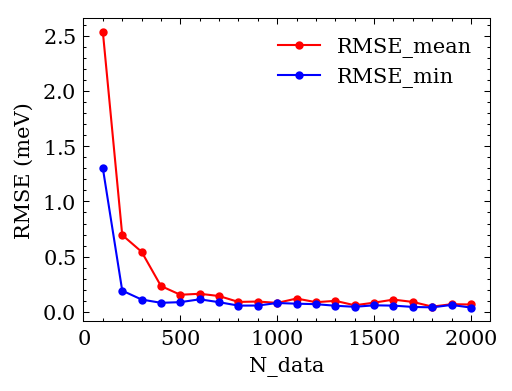

In [7]:
%matplotlib inline

with plt.style.context(["science", "no-latex"]):
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot()
    ax.plot(np.arange(100, 2100, 100), rmse_mean_list * 1.0e+03, "r.-", label="RMSE_mean")
    ax.plot(np.arange(100, 2100, 100), rmse_min_list * 1.0e+03, "b.-", label="RMSE_min")

    ax.set_xlabel("N_data")
    ax.set_ylabel("RMSE (meV)")

    ax.set_xlim([0, 2100])
    # ax.set_ylim([-0.1, 2.0])

    plt.legend()

In [8]:
df_al = pd.DataFrame({
    "N_data": np.arange(100, 2100, 100),
    "RMSE_mean": rmse_mean_list,
    "RMSE_min": rmse_min_list,
})

df_al.to_csv("active-learning.csv", index=False)

In [9]:
query_idx_txt = sorted(glob.glob(os.path.join(workdir, "*", "query_idx.txt")))[-1]
query_idx_txt

'/home/jhli/H2O-Ar-pes/cqpes-legacy-delta-machine-learning/al-model-2024-10-11 12:02:14.630890/query-018/query_idx.txt'

In [10]:
# query_idx_txt = "/home/jhli/H2O-Ar-pes/cqpes-legacy-delta-machine-learning/al-model-2024-10-11 11:07:09.729765/query-016/query_idx.txt"

query_idx = np.loadtxt(query_idx_txt, dtype=np.int32)
query_idx

array([ 2708,  7845, 11004, ..., 24005, 25365, 27743], dtype=int32)

In [11]:
V_delta_list = np.load("/home/jhli/H2O-Ar-pes/cqpes-legacy-delta-machine-learning/data/delta_V.npy").reshape((-1, 1))
V_low_list = np.load("/home/jhli/H2O-Ar-pes/cqpes-legacy-low-level/data/V.npy").reshape((-1, 1))
V_high_list = np.load("/home/jhli/H2O-Ar-pes/cqpes-legacy-high-level/data/V.npy").reshape((-1, 1))

In [31]:
V_high_list - V_low_list

array([[ 0.04155005],
       [ 0.04052543],
       [ 0.03947044],
       ...,
       [-0.0328833 ],
       [-0.0328833 ],
       [-0.0328833 ]])

In [32]:
V_delta_list

array([[ 0.04155005],
       [ 0.04052543],
       [ 0.03947044],
       ...,
       [-0.0328833 ],
       [-0.0328833 ],
       [-0.0328833 ]])

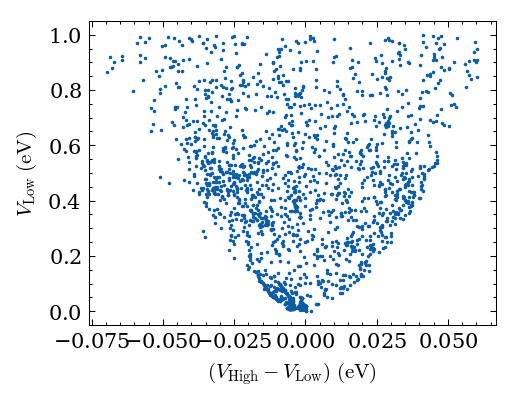

In [12]:
%matplotlib inline

with plt.style.context(["science", "no-latex"]):
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot()
    ax.scatter(V_delta_list[query_idx], V_low_list[query_idx], s=0.5)
    ax.set_xlabel(r"$(V_\mathrm{High} - V_\mathrm{Low}) \; \mathrm{(eV)}$")
    ax.set_ylabel(r"$V_\mathrm{Low} \; \mathrm{(eV)}$")

In [13]:
pd.DataFrame({
    "high-low": V_delta_list[query_idx].flatten(),
    "low": V_low_list[query_idx].flatten(),
}).to_csv("high-low.csv", index=False)

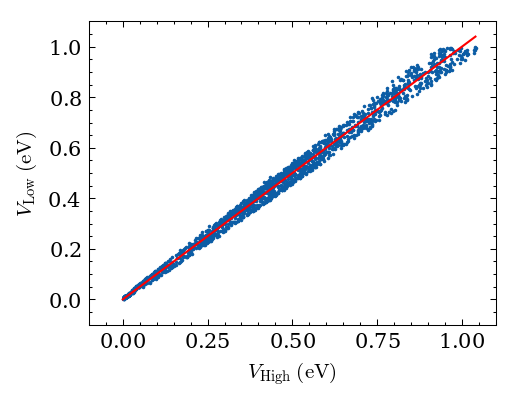

In [14]:
%matplotlib inline

with plt.style.context(["science", "no-latex"]):
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot()
    ax.scatter(V_high_list[query_idx], V_low_list[query_idx], s=0.5)
    ax.plot([0.0, 1.04], [0.0, 1.04], "r-")
    ax.set_xlabel(r"$V_\mathrm{High} \; \mathrm{(eV)}$")
    ax.set_ylabel(r"$V_\mathrm{Low} \; \mathrm{(eV)}$")
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])

In [15]:
from _libxyz import XYZMol

In [16]:
mol_list = XYZMol.from_traj("/home/jhli/H2O-Ar-pes/cqpes-legacy-low-level/rawdata/pes.xyz")

In [17]:
r_O_Ar_list = np.array([np.linalg.norm(mol.xyz[2, :] - mol.xyz[3, :]) for mol in mol_list]).reshape((-1, 1))

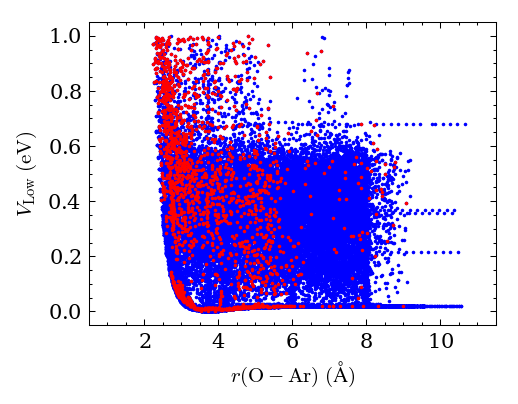

In [18]:
%matplotlib inline

with plt.style.context(["science", "no-latex"]):
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot()
    ax.scatter(r_O_Ar_list, V_low_list, s=0.5, c="b")
    ax.scatter(r_O_Ar_list[query_idx], V_low_list[query_idx], s=0.5, c="r")
    ax.set_xlabel(r"$r\mathrm{(O-Ar)} \; \mathrm{(\AA)}$")
    ax.set_ylabel(r"$V_\mathrm{Low} \; \mathrm{(eV)}$")

    ax.set_xlim([0.5, 11.5])

In [19]:
pd.DataFrame({
    "Ar-O": r_O_Ar_list.flatten(),
    "low": V_low_list.flatten(),
}).to_csv("Ar-O-low.csv", index=False)

In [20]:
pd.DataFrame({
    "Ar-O": r_O_Ar_list[query_idx].flatten(),
    "low": V_low_list[query_idx].flatten(),
}).to_csv("Ar-O-low-selected.csv", index=False)

In [21]:
from potfit_nn import PotfitNN

In [22]:
ckpt_path = os.path.join(workdir, "query-018", "model-001")

model = PotfitNN(
    weights_file=os.path.join(ckpt_path, "weights-1.txt"),
    biases_file=os.path.join(ckpt_path, "biases-1.txt"),
)

In [23]:
p_list = np.load("/home/jhli/H2O-Ar-pes/cqpes-legacy-low-level/data/p.npy")[:, 1:]
V_pred_list = np.apply_along_axis(model.forward, axis=1, arr=p_list)

pd.DataFrame({
    "V": V_delta_list[query_idx].flatten(),
    "V_pred": V_pred_list[query_idx].flatten(),
}).to_csv("H2O-Ar-delta-results.csv", index=False)

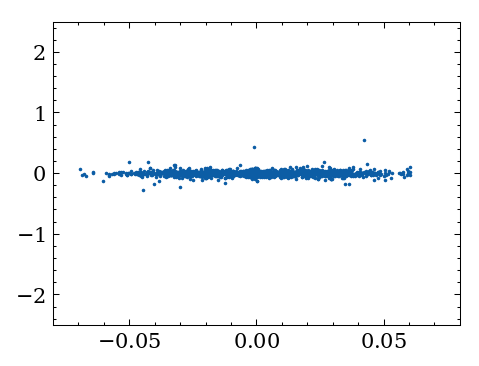

In [24]:
%matplotlib inline

with plt.style.context(["science", "no-latex"]):
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot()
    ax.scatter(V_delta_list[query_idx], (V_delta_list[query_idx] - V_pred_list[query_idx]) * 1.0e+03 , s=0.5)
    # ax.set_xlabel(r"$V_\mathrm{High} \; \mathrm{(eV)}$")
    # ax.set_ylabel(r"$V_\mathrm{Low} \; \mathrm{(eV)}$")
    ax.set_xlim([-0.08, 0.08])
    ax.set_ylim([-2.5, 2.5])

In [25]:
V_pred_list.shape, V_low_list.shape

((32524, 1), (32524, 1))

In [26]:
V_fit_high_list = V_pred_list + V_low_list

In [28]:
V_fit_high_list[:10]

array([[0.98551823],
       [0.92654138],
       [0.86951585],
       [0.81446474],
       [0.76140705],
       [0.71035806],
       [0.661329  ],
       [0.61432681],
       [0.56935446],
       [0.52641025]])

In [29]:
V_high_list = V_delta_list + V_low_list

In [30]:
V_high_list[:10]

array([[0.98560675],
       [0.92663804],
       [0.86962039],
       [0.81457638],
       [0.76152479],
       [0.71048059],
       [0.66145547],
       [0.61445596],
       [0.56948533],
       [0.52654196]])

In [27]:
np.save("V_fit_high.npy", V_fit_high_list)
np.save("V_fit_high_min.npy", V_fit_high_list.min())
np.save("V_fit_high_max.npy", V_fit_high_list.max())

In [33]:
def scale(
    t: np.array,
    t_min: np.array,
    t_max: np.array,
):
    t_scaled = 2 * (t - t_min) / (t_max - t_min) - 1
    np.nan_to_num(t_scaled, copy=False)
    return t_scaled

In [34]:
y = scale(V_fit_high_list, V_fit_high_list.min(), V_fit_high_list.max())

In [35]:
np.save("y_fit_high.npy", y)